# Time Series
#### Exploring ARIMA & Prophet for Time Series Data

## What's Covered in this Notebook?
This notebook will demonstrate the implementation of ARIMA and its related components from the statsmodels library, the use of Facebook's Prophet forecasting model, as well as a basic Recurrent Neural Network (RNN) for applying deep-learning to a dataset.

Summary:
* Statsmodels Library
* Stationarity Test (using ADFuller aka. Dickey-Fuller)
* Unit Roots
* Understanding Autocorrelation (ACF) & Partial Autocorrelation (PACF) Functions
* Dealing with Seasonality
* Utilizing SARIMAX
* Understanding Akaike information criterion
(AIC) & Bayesian Information Criterion (BIC)

In [1]:
## Create a new python envirnoment prior to installing requirements!
# !pip install -r requirements.txt

In [2]:
import warnings

warnings.simplefilter('ignore', FutureWarning)

## Toronto Temperature Data

![Toronto](https://curiocity.com/wp-content/uploads/2023/05/BeFunky-collage-15-1265x600.jpg)

We'll be examining the changes in temperature from 1937 to 2018 with the intention of being able to accurately predict the year 2018's temperatures by modeling previous years.

By modeling the temperature's we'll be able to predict future temperatures as well as capture overarching trends in the data (e.g. are temperatures getting warmer over time?).

## Importing & Formatting Dataset

In [3]:
import pandas as pd

In [4]:
toronto = pd.read_csv('data/toronto_temp.csv')
# Cleaning Up 'Year' Column
toronto['Year'] = toronto['Year'].replace({',': ''}, regex=True)
toronto['Year'] = pd.to_numeric(toronto['Year'])
# toronto['Year'].dtype # 'int64'
# toronto.head()

In [5]:
print(f'Toronto Min Year {toronto.Year.min()}')
print(f'Toronto Max Year {toronto.Year.max()}')

Toronto Min Year 1937
Toronto Max Year 2018


In [6]:
# Converting to Farenheit for American Audiences...
def celcius2farenheit(c):
    f = c * 1.8000 + 32.00
    return f

toronto['Mean Temp (F)'] = toronto['Mean Temp (C)'].apply(celcius2farenheit)

In [7]:
celcius = False 
temp_column = "Mean Temp (F)" if celcius is False else "Mean Temp (C)"

In [8]:
print(f'>>> Total Number of Rows in Toronto:   {len(toronto)}')
print(f'>>> Number of Null Rows in "{temp_column}" Column:  {toronto[temp_column].isnull().sum()}')

>>> Total Number of Rows in Toronto:   2889
>>> Number of Null Rows in "Mean Temp (F)" Column:  13


In [9]:
# Using Previous Day's Value to Fill Missing Values
toronto.bfill(inplace=True)
print(f'>>> Number of Null Rows in "{temp_column}" Column:  {toronto[temp_column].isnull().sum()}')

>>> Number of Null Rows in "Mean Temp (F)" Column:  0


In [10]:
# Reformatting Date/Time Column
datetime=['Year','Month','Day'] 
toronto['Date'] = toronto[datetime].apply(lambda x: '-'.join(x.values.astype(str)), axis=1)
toronto['Date'] = pd.to_datetime(toronto['Date'])

# Consolidating DataFrame to Date & Mean Temperature
toronto = toronto[['Date', temp_column]]

# Resampling Temperatures on Montly Averages
toronto= toronto.resample('MS', on='Date',origin='epoch').mean() #Use 'MS' for Month Start
toronto.head()



,Mean Temp (F)
Date,
1937-11-01,37.94
1937-12-01,24.08
1938-01-01,19.04
1938-02-01,25.34
1938-03-01,34.52


In [11]:
# Separating Training & Testing Datasets
train = toronto[:-11] # Contains Months from years 1937 to 2017
test = toronto[-11:] # Contains Months in year 2018

# Visualizing the Data

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [13]:
def dataviz(data:pd.DataFrame, y:str=temp_column, test_years:int=1):
    max_year, min_year = data.index.max().year, data.index.min().year
    start = min_year if max_year-min_year <= 8 else (max_year-8)
    end = max_year + 1
    section = 'Training' if end-start > test_years else 'Testing'

    plt.figure(figsize=(10,4))
    plt.plot(data.loc[f'{start}-01':][y])
    plt.title(f'Toronto Temperatures over Time | {section} Data', fontsize=20)
    plt.ylabel('Temperatures', fontsize=16)
    for year in range(start, end):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

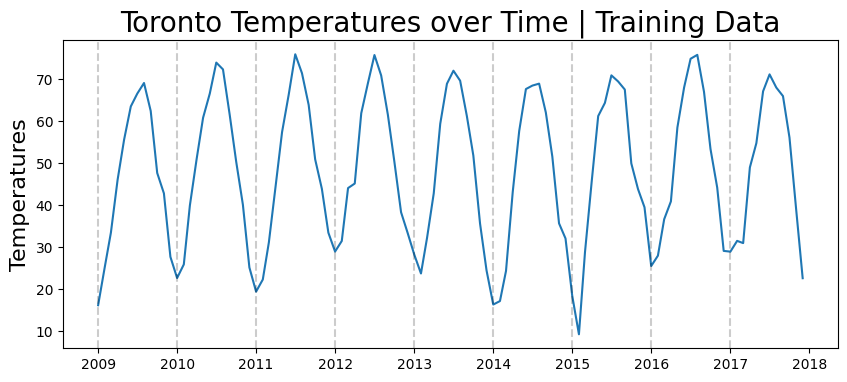

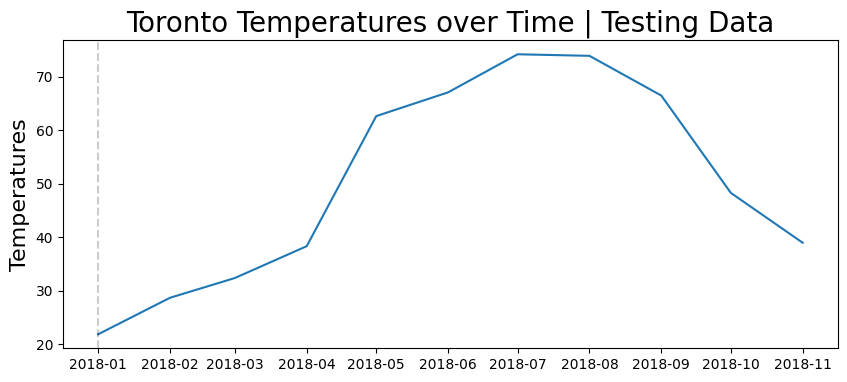

In [14]:
# Visualize Training Data
dataviz(train)
dataviz(test)

# Stationarity & The Dickey-Fuller Test
Stationarity deals with how consistent a time-series remains with respect to time. A stationary time-series should not see any significant spikes or upward/downward trends but rather stable cycles that don't see significant changes through time.

To properly apply ARIMA models the time-series needs to be stationary. To objectively check for stationarity we use the **Augmented Dickey-Fuller test** (adfuller) which can be imported from the statsmodels library. **If the p-value is below 0.05 the time-series is significantly stationary**. The adfuller test checks for unit roots within the time-series which cause problems with statistical inference.

> NOTE:
> The "I" in "ARIMA" refers to "Integrated", which deals with stationarity. If a function is not already stationary, it will need to be "differenced" to conform the series to be **time independent**. Please visit the article [The I in ARIMA modelling and Random Walk time series](https://medium.com/@kfoofw/the-i-in-arima-modelling-and-random-walk-time-series-1fb29271e2c1)

#### Super-Quick Math Explanation

The Augmented Dickey Fuller Test checks for the existence of a unit root within a time series. We start of with the formula for a given time series:

### $$y_{t} = \mu + \phi y_{t-1} + \epsilon_{t}$$

This formula is the most basic time series formula as an AR(1) model. The augmented version of the test accounts for more complex model. Using this basic model as an example, there will be some coefficient $\phi$ ("phi") that assumes the existence of a unit root. If a unit root exists, $\phi$ will be equal to one. If a unit root does not exist, $\phi$ will be less than one.

 ### $$ [H_{0}: \phi = 1, H_{1}: \phi < 1]$$

This coefficient $\phi$ minus one will represent our $\delta$ ("delta") coefficient value:

### $$\delta = (\phi - 1)$$

 If a unit root exists delta will become zero because $\phi$ will be equal to one. However, if $\phi$ is less than one, then $\delta$ will be some negative number.
 
 ### $$ [H_{0}: \delta = 0, H_{1}: \delta < 0]$$


  By finding the T-Value of the delta coefficient and comparing the T-Value to the Critical Value found on the Dickey Fuller Distribution we can determine if the series is stationary. **Ultimately, we are simply determining if $\delta$ is equal to zero or less than zero as a means of checking for unit roots.** If the T-Value is less than the Critical Value we can safely reject the null-hypothesis that a unit root exists and continue with our modeling process. If the T-Value is greater than the Critical Value we will need to apply some additional processing before proceeding. 

#### P-Value

To clearly understand whether the Time Series is Stationary we use find the P-Value to make the same statements about the null and alternate hypotheses. Generally, if the P-Value is below 0.05 we can reject the null hypothesis. Otherwise, we will need to reconfigure the time series to become stationary (usually through a process known as [differencing](https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/))

 ### $$ [H_{0}: p > 0.05, H_{1}: p \leq 0.05]$$

 > Note: For more on the Mathematics behind this concept please see the following YouTube Video on the [Augmented Dickey Fuller Test](https://www.youtube.com/watch?v=1opjnegd_hA&list=TLPQMDUwMjIwMjTiuNo9q37cDw&index=3)


In [15]:
from statsmodels.tsa.stattools import adfuller

#function created for easier interpretation of adfuller results
def adf_test(series:pd.Series, num_round:int=5):
    results = adfuller(series)
    print(f'ADF Statistic: {round(results[0],num_round)}')
    print(f'P-Value: {round(results[1],num_round)}')
    if results[1] <= 0.05:
        print('The Time Series is Significantly Stationary!!! 👍')
    else:
        print('The Time Series is NOT Significantly Stationary... 😔')

adf_test(train)

ADF Statistic: -3.76246
P-Value: 0.00332
The Time Series is Significantly Stationary!!! 👍


## ACF & PACF


To determine which order model to use we can take a look at the ACF and PACF charts. Generally speaking, points above the error-band within the graph are likely to be significant in determining future values. ACF is usually a great way to determine the order of the Moving Average. PACF is a great way to determine the order of the Auto-Regression aspect of the trend.

Summary
* PACF helps us identify the appropriate "Order" for the "AR" in ARIMA
* ACF helps us identify the appropriate "Order" for the "MA" in ARIMA
* "AR" refers to "Auto-Regression"
* "MA" refers to "Moving Average"

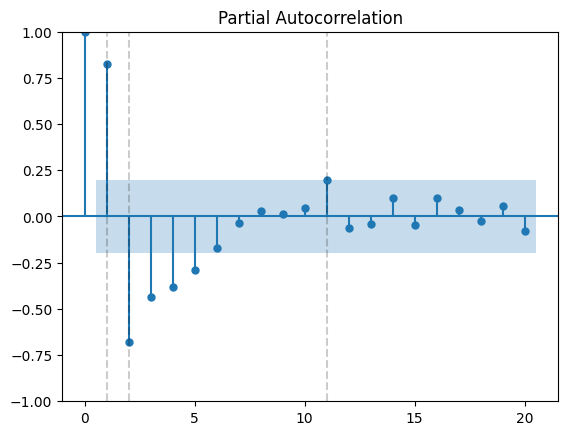

>>> PACF - Significant Lags Detected:  [1, 2, 11]




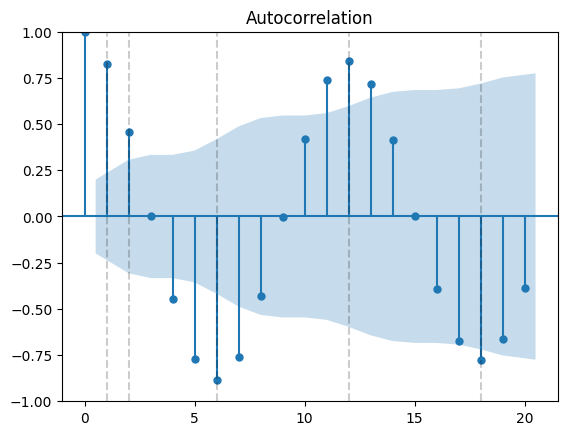

>>> ACF - Significant Lags Detected:  [1, 2, 6, 12, 18]




In [16]:
# Plotting PACF with Detected Lags
plot_pacf(train.loc['2010-01':][temp_column])
lags_detected = [1, 2, 11]
for lag in lags_detected:
    plt.axvline(x=lag,color='k', linestyle='--', alpha=0.2)
plt.show()
print(f'>>> PACF - Significant Lags Detected:  {lags_detected}\n\n')

# Plotting ACF with Detected Lags
plot_acf(train.loc['2010-01':][temp_column])
lags_detected = [1, 2, 6, 12, 18]
for lag in lags_detected:
    plt.axvline(x=lag,color='k', linestyle='--', alpha=0.2)
plt.show()
print(f'>>> ACF - Significant Lags Detected:  {lags_detected}\n\n')

## Seasonal Decomposition
We can implement the 'seasonal_decompose' function from the statsmodels library to investigate the existence of seasonality within a time series. By observing the visualization produced by the seasonality chart we can identify whether a repeating sequence in fact exists within the series to indicate seasonality.

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [18]:
res = seasonal_decompose(train.loc['2010-01':][temp_column])

Text(0.5, 1.0, 'Seasonality')

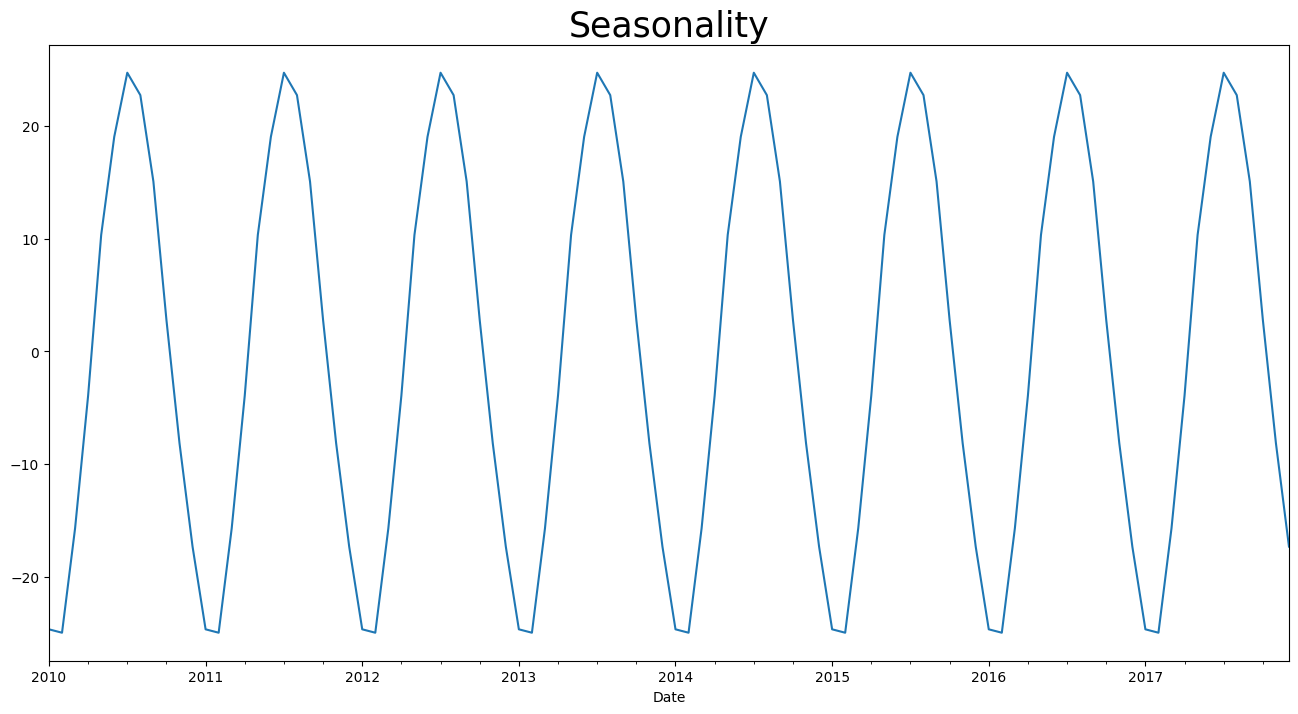

In [19]:
res.seasonal.plot(figsize=(16,8)).set_title('Seasonality', fontdict={'fontsize': 25, 'fontweight': 'medium'})

In [20]:
# res.trend.plot(figsize=(16,8)).set_title('Trend', fontdict={'fontsize': 20, 'fontweight': 'medium'})

## Auto ARIMA
These days it's much easier to implement an automatic ARIMA method to quickly identify the best order of ARIMA to apply to our dataset. We will quickly implement an Auto ARIMA model to our dataset to find the best configuration of ARIMA for the dataset and make predictions on our Test Set.

> Notes on the auto_arima parameters 
> * **m** is the length of a seasonal period, meaning the number of data points in each period. For the purposes of this dataset we have aggregated the data by months. Therefore, we have 12 months per year (year representing the 'period' in this scenario). We can verify this by observing the complete cycle that happens from one year to the next within the seasonality graph above. So we will be setting **m=12**.

### AIC & BIC
Akaike Information Criterion (AIC) & Bayesian Information Criterion (BIC) are powerful indicators of which orders of ARIMA fit the dataset best. Having a lower AIC indicates a better performing model. We also want BIC to be lower, but BIC also informs us if the model is closer to the true hidden function behind the data. We will see Auto ARIMA making it's ultimate decision on the best model fit based on which model had the lowest AIC score.
> NOTE: 
> * Lower AIC & BIC is Better 👍

In [21]:
from pmdarima import auto_arima

In [22]:
auto_arima(train[temp_column], trace=True,).summary() # trace prints statuses on the fits

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5272.299, Time=1.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8256.403, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7074.109, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7372.318, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10230.013, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=6532.022, Time=0.40 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5698.140, Time=1.27 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=5700.841, Time=1.40 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.41 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=6737.510, Time=0.26 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=6431.331, Time=0.52 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=5560.039, Time=1.02 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=5290.586, Time=1.18 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=6537.997, Time=0.22 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  962
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -2630.149
Date:                Mon, 05 Feb 2024   AIC                           5272.299
Time:                        14:01:23   BIC                           5301.513
Sample:                    11-01-1937   HQIC                          5283.423
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     12.3068      0.039    319.652      0.000      12.231      12.382
ar.L1          1.7305      0.001   2201.923      0.000       1.729       1.732
ar.L2         -0.9980      0.001  -1415.438      0.000      -0.999      -0.997
ma.L1         -1.6022      0.016   -100.303      0.000      -1.633      -1.571
ma.L2          0.8995      0.017     54.394      0.000       0.867       0.932
sigma2        13.6032      0.571     23.832      0.000      12.484      14.722
===================================================================================
Ljung-Box (L1) (Q):                  46.52   Jarque-Bera (JB):                 9.28
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               1.28   Skew:                            -0.10
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
from statsmodels.tsa.arima.model import ARIMA

In [24]:
order = (2,0,2) # SARIMAX(2, 0, 2), see above SARIMAX Results summary under Model
arima_model = ARIMA(train, order=order)
arima_model = arima_model.fit()
arima_model.summary()

c:\Users\ajgal\anaconda3\envs\vip\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Mean Temp (F)   No. Observations:                  962
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -2617.558
Date:                Mon, 05 Feb 2024   AIC                           5247.117
Time:                        14:01:24   BIC                           5276.331
Sample:                    11-01-1937   HQIC                          5258.241
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.0216      0.128    359.974      0.000      45.771      46.272
ar.L1          1.7320      0.000   1.33e+04      0.000       1.732       1.732
ar.L2         -0.9999   4.41e-05  -2.27e+04      0.000      -1.000      -1.000
ma.L1         -1.7009      0.008   -213.862      0.000      -1.717      -1.685
ma.L2          0.9782      0.008    124.945      0.000       0.963       0.994
sigma2        13.2555      0.561     23.642      0.000      12.157      14.354
===================================================================================
Ljung-Box (L1) (Q):                  74.53   Jarque-Bera (JB):                 6.30
Prob(Q):                              0.00   Prob(JB):                         0.04
Heteroskedasticity (H):               1.41   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: title={'center': 'ARIMA vs. Actual'}, xlabel='Date'>

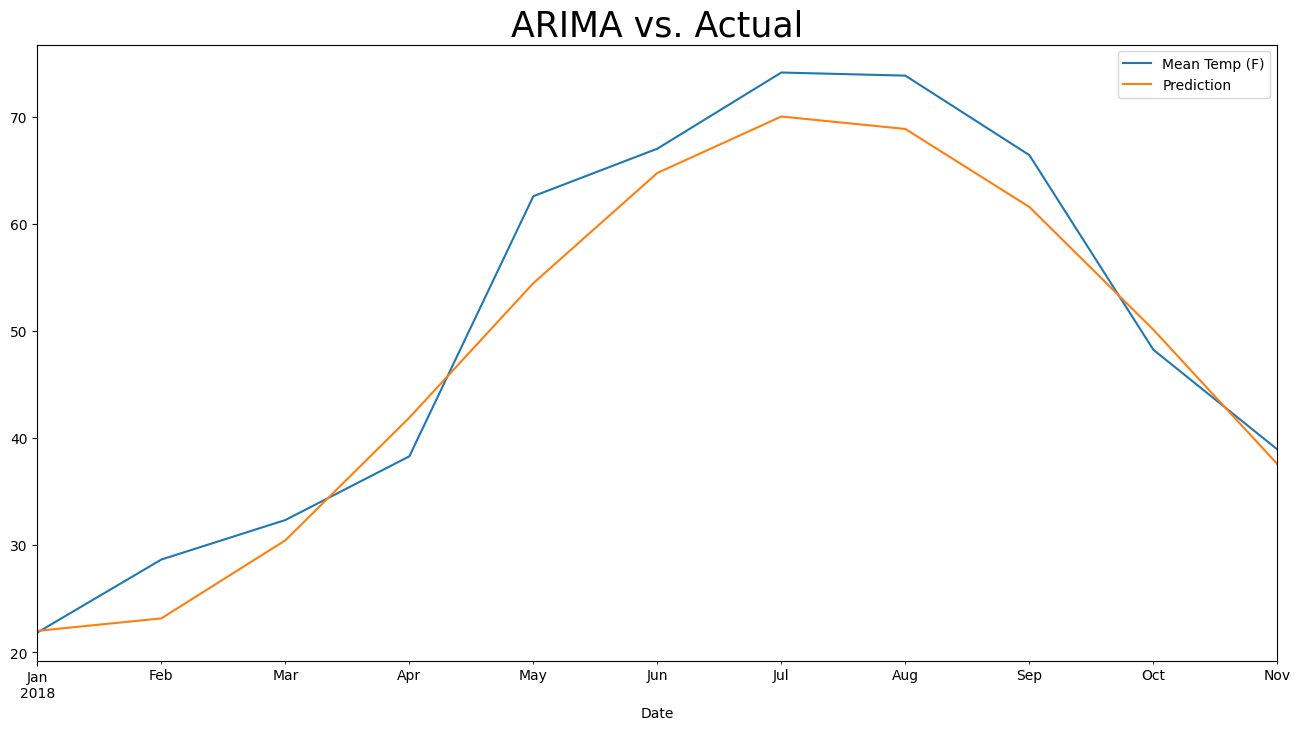

In [25]:
start = len(train)
end = len(train) + len(test) - 1
predictions = arima_model.predict(start, end).rename('Prediction')

ax = test[temp_column].plot(legend=True, figsize=(16,8))
ax.set_title('ARIMA vs. Actual', fontdict={'fontsize': 25, 'fontweight': 'medium'})
predictions.plot(legend=True)

## Measuring ARIMA Performance

To measure the fit of a given model over a time series we will simply take the residuals (e.g. the difference between true values and predicted values) and check if the curve resembles a normal distribution ("bell-curve"). Additionally, we will take a look at some additional regression metrics (particularly the percentages) to see if the model performs well.

In [26]:
import seaborn as sns

Text(0.5, 1.0, 'ARIMA Residuals')

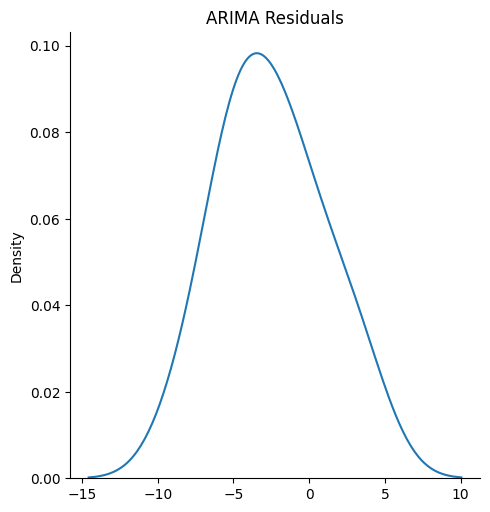

In [27]:
residuals = predictions - test[temp_column]
sns.displot(data=residuals,kind='kde') 
plt.title("ARIMA Residuals")

In [28]:
from sklearn import metrics
import numpy as np

def print_metrics(y_true:pd.Series, y_pred:pd.Series):

    MAE = metrics.mean_absolute_error(y_true,y_pred)
    MAPE = metrics.mean_absolute_percentage_error(y_true,y_pred) * 100
    MSE = metrics.mean_squared_error(y_true,y_pred)
    RMSE = np.sqrt(metrics.mean_squared_error(y_true,y_pred))
    MedAE = metrics.median_absolute_error(y_true,y_pred)
    MedAPE = np.median((np.abs(np.subtract(y_true.tolist(), y_pred.tolist())/ y_true))) * 100

    print('MAE:', np.round(MAE,2))
    print('MAPE:', np.round(MAPE,2),'%')
    print('MSE:', np.round(MSE,2))
    print('RMSE:', np.round(RMSE,2))
    print('MedAE:', np.round(MedAE,2))
    print('MedAPE:',np.round(MedAPE,2),'%')

    mdict = dict(
        mae=MAE,
        mape=MAPE,
        mse=MSE,
        rmse=RMSE,
        medae=MedAE,
        medape=MedAPE,
    )
    return mdict

In [29]:
arima_metrics = print_metrics(test[temp_column], predictions)

MAE: 3.52
MAPE: 7.14 %
MSE: 17.15
RMSE: 4.14
MedAE: 3.61
MedAPE: 5.87 %


# Prophet by Facebook

[Prophet](https://facebook.github.io/prophet/) is an open-source tool released by Facebook's Data Science team available in Python & R. Prophet is an algorithm for forecasting time series data based on an additive regrssion model where non-linear trends are fit with yearsly, weekly, and daily seasonality, plus holiday effects (as applicable). Prophet works best  with time series having strong seasonal effects and several seasons of historical data.

Prophet implements the additive regression model with four elements:
* **Piecewise Linear**, Prophet automatically detects change points in the data and identifies changes in trends
* **Yearly Seasonal component** modeled using Fourier Series
* **Weekly Seasonal component**
* **Optional Holiday List** that can be manually provided

> [>>> READ THE PAPER -- Forecasting at Scale](https://peerj.com/preprints/3190/)

In [30]:
from prophet import Prophet
# require plotly installed for Interactive Plots

In [31]:
columns = {
    'Date':'ds',
    temp_column: 'y',
}
toronto_prophet = toronto.reset_index()
toronto_prophet = toronto_prophet.rename(columns=columns)
ptrain = toronto_prophet[:-11]
ptest = toronto_prophet[-11:]

In [32]:
ptrain.head()

,ds,y
0,1937-11-01,37.94
1,1937-12-01,24.08
2,1938-01-01,19.04
3,1938-02-01,25.34
4,1938-03-01,34.52


In [33]:
m = Prophet()
m.fit(ptrain)
forecast = m.predict(ptest)

14:01:25 - cmdstanpy - INFO - Chain [1] start processing
14:01:25 - cmdstanpy - INFO - Chain [1] done processing


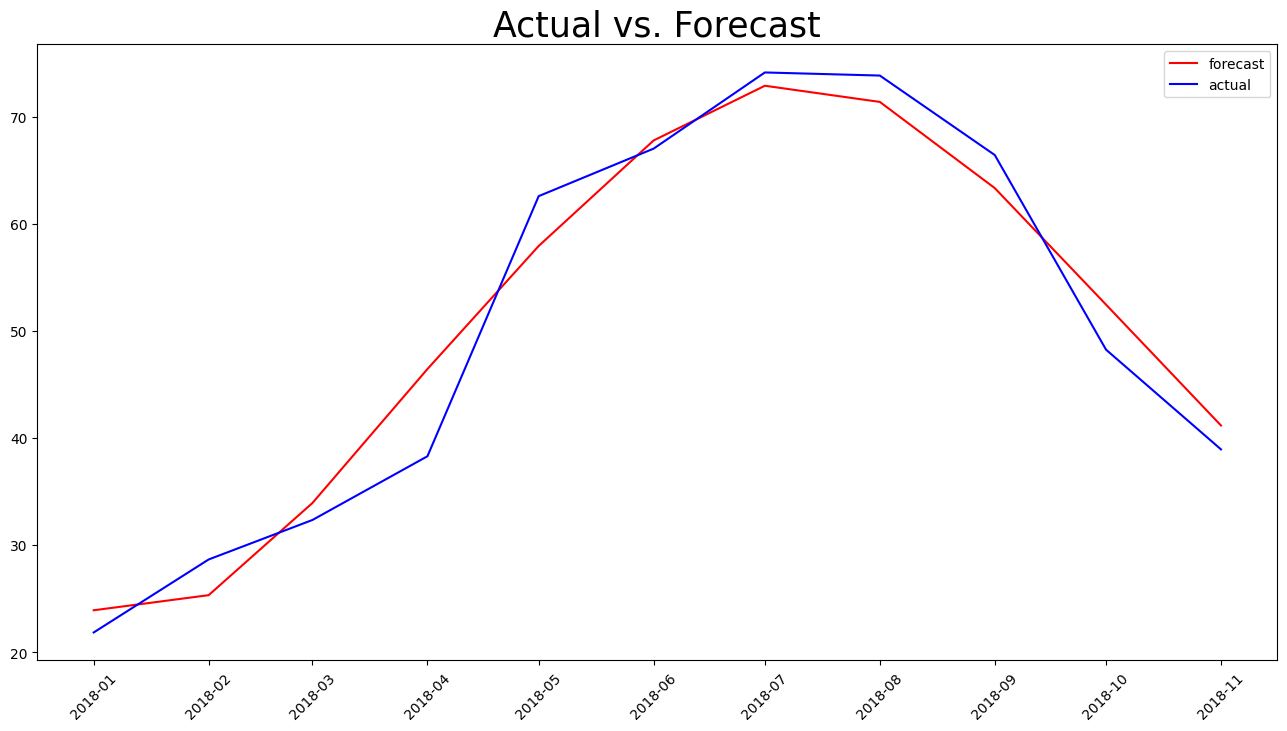

In [34]:
ax = plt.figure(figsize=(16,8))
plt.plot(forecast.ds, forecast.yhat, color='r', label='forecast')
plt.plot(ptest.ds[-11:], ptest.y[-11:], color='b', label='actual')
plt.xticks(rotation=45)
plt.title('Forecast vs. Actual', fontdict={'fontsize': 25, 'fontweight': 'medium'})
plt.legend()

#### Prophet Components
In the following chart we will see the overall trend discovered in the temperature data as well as the yearly cycle that occurs within our dataset.

From the "trend" component we can see that temperature is rising linearly at a steady pace.

The "yearly" component shows that temperatures are highest in Spring & Summer (starting in March & ending in September) with a peak around September before falling in October.

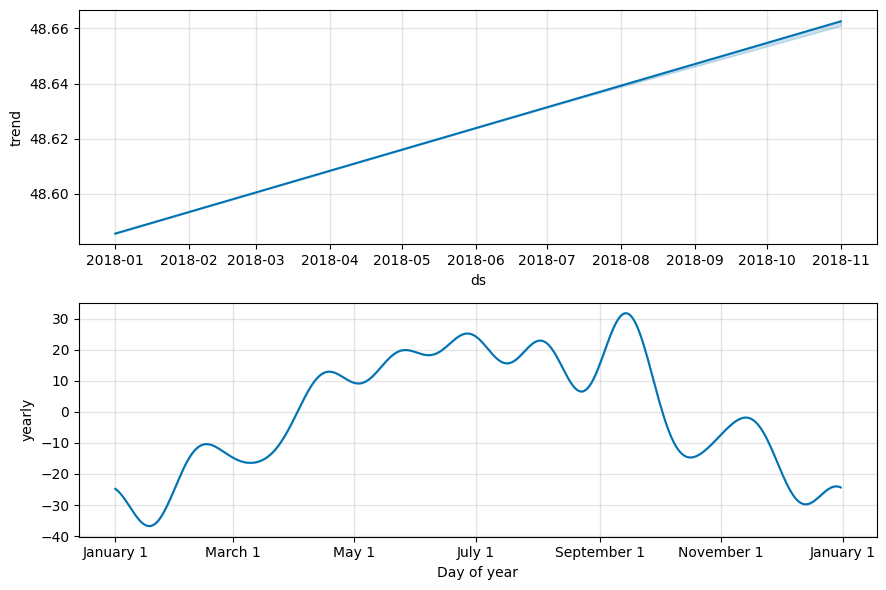

In [35]:
components = m.plot_components(forecast)

#### Prophet Performance

Text(0.5, 1.0, 'Prophet Residuals')

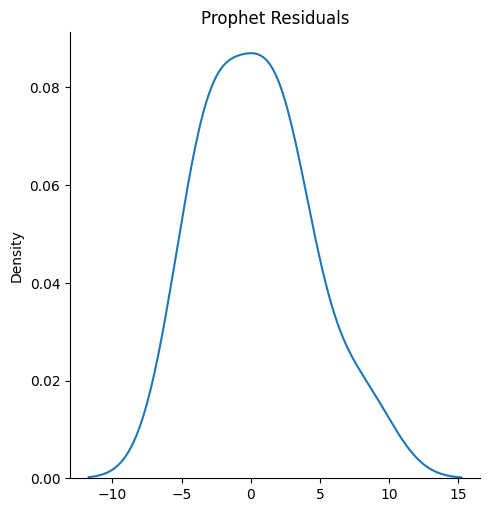

In [36]:
y_pred = forecast.yhat
y_true = ptest.y.reset_index(drop=True)

presiduals = y_pred - y_true
sns.displot(data=presiduals,kind='kde')
plt.title("Prophet Residuals")

In [37]:
prophet_metrics = print_metrics(y_true=y_true, y_pred=y_pred)

MAE: 3.07
MAPE: 7.27 %
MSE: 13.31
RMSE: 3.65
MedAE: 2.46
MedAPE: 5.73 %


## Model Comparison (ARIMA vs. PROPHET)

Seeing as the residuals for both models have a normal distribution, we'll need to take a closer look at the error metrics to determine which model is better suited to the dataset.

In [38]:
for (ak,av), (pk,pv) in list(zip(arima_metrics.items(), prophet_metrics.items())):
    print(f'>>> {ak.upper()}:    ARIMA={round(av,2)},  PROPHET={round(pv,2)}')

>>> MAE:    ARIMA=3.52,  PROPHET=3.07
>>> MAPE:    ARIMA=7.14,  PROPHET=7.27
>>> MSE:    ARIMA=17.15,  PROPHET=13.31
>>> RMSE:    ARIMA=4.14,  PROPHET=3.65
>>> MEDAE:    ARIMA=3.61,  PROPHET=2.46
>>> MEDAPE:    ARIMA=5.87,  PROPHET=5.73


## Conclusion

Both models do a fairly good job of forecasting future temperatures with similar error metrics results. However, based on the feedback from those metrics we may determine that Prophet performs slightly better than ARIMA in this scenario. 